# Multimodal Retrieval Augumented Generation (RAG) Inference

***This notebook works best with the `conda_python3` on the `ml.t3.large` instance***.

---

This notebook performs the following steps:

1. Takes in a user question, and extracts entities from that question

1. Uses the entities from the question, performs `prefiltering` and extracts the top `k` hits from the index based on the `entities matching`

1. Uses an `LLM in the loop` to go over each `k` hit, check for if the answer to the question is given in that hit and if not, move to the next `hit` until the answer is found. If the answer is not found in any, return `I don't know`.

1. Use an eval dataset that a user provides with a question bank, iterate through each question and query the `text` and the `image indexes` to look for answers to the questions in the eval dataset.

1. During retrieval, answers are searched from both, the `text` and the `image` index to provide a combined answer.

***Make sure to check for the data ingested into both indices. Data ingestion might take a couple of minutes depending on the amount of data***

## Step 1. Setup

Install the required Python packages and import the relevant files.

In [1]:
# install the requirements
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
# import necessary libraries to run this notebook
import os
import ray
import json
import time
import yaml
import boto3
import logging
import litellm
import requests
import botocore
import opensearchpy
import numpy as np
import pandas as pd
import globals as g
from PIL import Image
from pathlib import Path
from litellm import completion
from IPython.display import Image
from urllib.parse import urlparse
from botocore.auth import SigV4Auth
from pandas.core.series import Series
from sagemaker import get_execution_role
from botocore.awsrequest import AWSRequest
from typing import List, Dict, Tuple, Optional
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from utils import get_cfn_outputs, get_text_embedding, get_llm_response, get_question_entities, load_and_merge_configs

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# load the merged config file - user config file, and parent config file
config = load_and_merge_configs(g.CONFIG_SUBSET_FILE, g.FULL_CONFIG_FILE)
logger.info(f"config file -> {json.dumps(config, indent=2)}")

[2024-07-25 00:18:21,334] p17714 {1465141196.py:3} INFO - config file -> {
  "aws": {
    "cfn_stack_name": "multimodal-blog4-stack",
    "os_service": "aoss"
  },
  "dir_info": {
    "source_dir": "data",
    "metrics_dir_name": "metrics",
    "img_path": "images",
    "txt_path": "text_files",
    "extracted_data": "extracted_data",
    "json_img_dir": "img_json_dir",
    "json_txt_dir": "text_json_dir",
    "manually_saved_images_path": "manually_saved_imgs",
    "prompt_dir": "prompt_templates",
    "image_description_prompt": "image_description_prompt.txt",
    "search_in_images_template": "retrieve_answer_from_images_prompt.txt",
    "search_in_text_template": "retrieve_answer_from_texts_prompt.txt",
    "extract_entities_from_user_question": "extract_question_entities_prompt.txt",
    "final_combined_llm_response_prompt": "final_combined_response_prompt_template.txt",
    "final_llm_as_a_judge_summary_analysis": "claude_final_summary_analysis_prompt.txt",
    "extract_image_enti

In [5]:
region: str = boto3.Session().region_name
os_service: str = config['aws']['os_service']

## Step 2. Create two OpenSearch clients for images and texts separately
---

We create an OpenSearch client so that we can query the vector database for embeddings (pdf files) similar to the questions that we might want to ask of our `PDF file`

Get the name of the OpenSearch Service Serverless collection endpoint and index name from the CloudFormation stack outputs.

In [6]:
outputs = get_cfn_outputs(config['aws']['cfn_stack_name'])
host = outputs['MultimodalCollectionEndpoint'].split('//')[1]
text_index_name = outputs['OpenSearchTextIndexName']
img_index_name = outputs['OpenSearchImgIndexName']
logger.info(f"opensearchhost={host}, text index={text_index_name}, image index={img_index_name}")

[2024-07-25 00:18:21,486] p17714 {176139677.py:5} INFO - opensearchhost=p8iwxd53ehl4qz5no03j.us-west-2.aoss.amazonaws.com, text index=texts, image index=images


In [7]:
session = boto3.Session()
credentials = session.get_credentials()
auth = AWSV4SignerAuth(credentials, region, os_service)

# Represents the OSI client
os_client= OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

[2024-07-25 00:18:21,523] p17714 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## Step 3. Read for RAG

We now have all the pieces for RAG. Here is how we talk to our PDF files.

1. Extract entities from the `question`.

1. Using the entites in the question, perform a `prefilter` step to get the content that matches the entities from the question in the `text` and `image` indexes the most.

1. Based on the top `k` results, use an `LLM in a loop` that you can configure in the [config.yaml](`config.yaml`) file as a check to verify if the answer to the question is in that `hit` and if not, move to the next `hit` to look for an answer. 

1. Responses from each image (if valid and if they are contained in the `hit`) are added as context to the final context. At the end, all the responses are aggregated into a final context that is run through by a final LLM call to give a final response to the question.

In [8]:
endpoint_url: str = g.BEDROCK_EP_URL.format(region=region)
bedrock = boto3.client(service_name="bedrock-runtime", endpoint_url=endpoint_url)

### Perform `prefiltering`
---

The `find_similar_data_with_entities` function performs a [knn-prefiltering]('https://opensearch.org/docs/latest/search-plugins/knn/filter-search-knn/'). It takes in the question entites extracted from the question asked, and searches for relevant docs that have similar entities in the `metadata.entities` field that was added during the `data ingestion` step for both `text` and `image` indexes.

In [9]:
def find_similar_data_with_entities(text_embedding, size: int, os_client, index_name: str, question_entities: List[str]):
    """
    This function is used to prefilter the responses only with images/texts that have entities that match
    with the entities provided in the question. Once the documents are refiltered, the search from the index
    is returned.
    """
    should_clauses: List[str] = []
    # Convert filter_string to lowercase to ensure case-insensitive matching
    q_entities_lower: str = question_entities.lower()
    q_entities_upper: str = question_entities.upper()
    # entities can either be lower case or upper case. search for both cases is supported
    question_entities_variants = [q_entities_lower, q_entities_upper]
    logger.info(f"Entities extracted: {question_entities_variants}")
    for word in question_entities_variants:
        for entity in word.split(","):
            should_clauses.append({
                "wildcard": {
                    "metadata.entities": {
                        # wildcard queries are to search for terms that match a wildcard pattern
                        # in this case, we are searching for an entity within the text embedding
                        "value": f"*{entity.strip()}*",
                        "case_insensitive": True
                    }
                }
            })
    query = {
        "size": size,
        "query": {
            "bool": {
                "must": {
                    "knn": {
                        "vector_embedding": {
                            "vector": text_embedding,
                            "k": size
                        }
                    }
                },
                "filter": {
                    "bool": {
                        "should": should_clauses,
                        # should match at least a single entity to fetch a response. Increase if there
                        # is a lot being asked in the question
                        "minimum_should_match": config['inference_info']['minimum_entities_to_match_from_question']
                    }
                }
            }
        }
    }
    try:
        content_based_search = os_client.search(body=query, index=index_name)
    except Exception as e:
        logger.error(f"error occured while querying OpenSearch index={index_name}, exception={e}")
        content_based_search = None
    return content_based_search

In [10]:
def get_nearest_img_search_response(nearest_image_path: str, prompt: str, modelId: str) -> str:
    """
    This function takes in the file path that is most similar to the text embeddings
    of the question, returns the image and checks for if the text description does not
    contain the answer, directly search for the answer in the selected image.
    """
   # extract the file name from the nearest image path stored in s3
    filename: str = os.path.basename(nearest_image_path)
    local_directory: str = os.path.join(g.IMAGE_DIR, 'b64_images')
    local_image_path = os.path.join(local_directory, filename.replace('.jpg', '.b64'))
    logger.info(f"Nearest image path being used for search: {local_image_path}")
    # read the file, MAX image size supported is 2048 * 2048 pixels
    try:
        with open(local_image_path, "rb") as image_file:
            input_image_b64 = image_file.read().decode('utf-8')
    except Exception as e:
        logger.error(f"Error reading base64 image from local directory: {e}")
        return None
    temperature = config['inference_parameters'].get('temperature', 0.1)
    max_tokens = config['inference_parameters'].get('max_tokens', 500)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "data:image/jpeg;base64," + input_image_b64
                    },
                },
            ],
        }
    ]
    # suppress the litellm logger responses
    lite_llm_logger = logging.getLogger('LiteLLM')
    lite_llm_logger.setLevel(logging.CRITICAL)
    ret = {
        "exception": None,
        "prompt": prompt,
        "completion": None,
        "time_taken_in_seconds":None,
        "completion_token_count": None,
        "prompt_token_count": None,
        "model_id": modelId,
        "input_token_cost": None,
        "output_token_cost": None,
    }
    try:
        response = completion(
            model=modelId,
            messages=messages,
            temperature=temperature, 
            max_tokens=max_tokens
        )
        # Suppress logging output
        logging.getLogger('LiteLLM').setLevel(logging.CRITICAL)
        # iterate through the entire model response
        for idx, choice in enumerate(response.choices):
            # extract the message and the message's content from litellm
            if choice.message and choice.message.content:
                # extract the response from the dict
                ret["completion"] = choice.message.content.strip()
        # Extract number of input and completion prompt tokens (this is the same structure for embeddings and text generation models on Amazon Bedrock)
        ret['prompt_token_count'] = response.usage.prompt_tokens
        ret['completion_token_count'] = response.usage.completion_tokens
        # Extract latency in seconds
        latency_ms = response._response_ms
        ret['time_taken_in_seconds']  = latency_ms / 1000
    except Exception as e:
        logger.error(f"exception={e}")
        ret["exception"] = e
    return ret

In [11]:
def response_from_text_extracted(prompt: str, modelId: str) -> dict:
    """
    This function takes in the prompt that checks whether the text file has a response to the question and if not, 
    returns "not found" to move to the next hit.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
            ],
        }
    ]
    temperature = config['inference_parameters'].get('temperature', 0.1)
    max_tokens = config['inference_parameters'].get('max_tokens', 500)
    # suppress the litellm logger responses
    lite_llm_logger = logging.getLogger('LiteLLM')
    lite_llm_logger.setLevel(logging.CRITICAL)
    ret = {
        "exception": None,
        "prompt": prompt,
        "completion": None,
        "completion_token_count": None,
        "prompt_token_count": None,
        "model_id": modelId, 
        "time_taken_in_seconds":None,
        "input_token_cost": None,
        "output_token_cost": None,
    }
    try:
        response = completion(
            model=modelId,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        # Suppress logging output
        logging.getLogger('LiteLLM').setLevel(logging.CRITICAL)
        # iterate through the entire model response
        for idx, choice in enumerate(response.choices):
            # extract the message and the message's content from litellm
            if choice.message and choice.message.content:
                # extract the response from the dict
                ret["completion"] = choice.message.content.strip()
        # Extract number of input and completion prompt tokens (this is the same structure for embeddings and text generation models on Amazon Bedrock)
        ret['prompt_token_count'] = response.usage.prompt_tokens
        ret['completion_token_count'] = response.usage.completion_tokens
        # Extract latency in seconds
        latency_ms = response._response_ms
        ret['time_taken_in_seconds']  = latency_ms / 1000
    except Exception as e:
        logger.error(f"exception={e}")
        ret["exception"] = e
    return ret

In [12]:
def sanitize_llm_response(llm_response: str) -> str:
    """
    This function sanitizes the LLM response generated. If the LLM response contains a sentence that has 
    "not found" or "Not found" within it, it returns only "not found" and no other characters. Case sensitivity does not matter.
    """
    string_to_match: str = "not found"
    sanitized_response: Optional[str] = None
    try:
        # Normalize the case for comparison
        normalized_response = llm_response.lower()
        if llm_response is None:
            sanitized_response: Optional[str] = None
        # Check if the normalized response contains the string "not found"
        if string_to_match in normalized_response:
            sanitized_response = string_to_match
        else:
            sanitized_response = normalized_response
    except Exception as e:
        logger.error(f"The LLM response cannot be sanitized: {e}")
        sanitized_response: Optional[str] = None
    return sanitized_response

### Prompts used in the RAG worklow
---

1. `direct_image_answer_retrieval_prompt`: This prompt is used for a check against retrieval from the `image index`. It checks for if the answer to the user question is given in the `image description` and if not, then it searches the image directly. If the answer is not in the `image description` or the `image` itself, it returns a `not found` message.

1. `direct_text_answer_retrieval_prompt`: This prompt is used for a check against retrieval from the `text index`. It checks for if the answer to the user question is given in the `text extracted` from the pdf page and if not, then returns a `not found` message.

In [13]:
image_retrieval_prompt_fpath: str = os.path.join(config['dir_info']['prompt_dir'],
                                                 config['dir_info']['search_in_images_template'])

txt_retrieval_prompt_fpath: str = os.path.join(config['dir_info']['prompt_dir'],
                                                 config['dir_info']['search_in_text_template'])
# read the image and text retrieval prompts that will be used in the RAG pipeline
direct_image_answer_retrieval_prompt: str = Path(image_retrieval_prompt_fpath).read_text()
direct_text_answer_retrieval_prompt: str = Path(txt_retrieval_prompt_fpath).read_text()

In [14]:
print(f"image retrieval prompt: {direct_image_answer_retrieval_prompt}")

image retrieval prompt: Human: Your role is to give the answer to the question in the <question></question> tags. If the image description in the <img_text_desc></img_text_desc> tags does not contain the answer to the question, then search the "data" for it. 
If the img_text_desc or the actual image in the "data", both do not contain the answer to the question below, then respond with two words only - "not found".

Refer to the img_text_desc and question below:

<img_text_desc>
{context}
</img_text_desc>

<question>
{question}
</question>

If the answer to the question is not in the image description, search the actual image provided in "data" and retrieve the answer directly from the image provided. Search for the question directly in the image in this case and retrieve the most accurate answer. Do not make up an answer.
If you cannot find an answer, search for it carefully in the image and for questions that ask for numbers, follow the instructions below in the <instructions></instru

In [15]:
print(f"text retrieval prompt: {direct_text_answer_retrieval_prompt}")

text retrieval prompt: Human: Your role is to give the answer to the question in the <question></question> tags. If the text description in the <text_desc></text_desc> tags does not contain the answer to the question, then respond with two words only - "not found".

Refer to the text_desc and question below:

<text_desc>
{context}
</text_desc>
<question>
{question}
</question>

If the answer to the question is not in the text desctipion, then respond with two words only: "not found"

Follow the instructions below in the <instructions></instructions> tags:

<instructions>
1. Search for the direct answer to the user question in the text.

2. If the context does not provide a direct answer to the user question, do not say anything. Just say "not found". Do not add statements like "After carefully examining the context, I could not find a direct... and so on" Just say "not found"

3. Do not add any tags in yor answer

4. scan for the direct answer to the user question. If there is more tha

### Get Inference: `Enhanced Multimodal RAG workflow`
---

The function `get_index_response` performs the following steps:

1. It takes in a list of tuples. Each tuple contains the `osi client` and `index name`.

1. Given both text and image indexes, it iterates through each tuple.

1. Extracts the entities from the `user question`, gets the text embeddings of the question and searches for the nearest hits using those entities as a `prefilter`.

1. After fetching the `vector db response`, it iterates through each content in every hit. For an image index, it uses an `LLM in the loop` to check for whether the answer is given in the image index and if not searches the image directly. If none have an answer, it returns a `not found` and moves to the next hit. For the text index, it uses an `LLM in the loop` to check if the extracted text has the answer to the question and if not, returns a `not found` message and moves to the next hit.

1. For all the valid responses from each hit and each index, the answer is stored as context for a final `LLM call`. Once all hits are traversed, an `LLM` is invoked to check if the context (that contains answers from all hits) contains the actual answer to the question.

In [16]:
# define global variables to track the total input tokens and output tokens for both the image
# and text response indices. This is tracked to give an average token count for a user query 
# at the end of the inference run
# Input tokens
INPUT_TOKENS_IMG: int = 0
INPUT_TOKENS_TEXT: int = 0
# Output tokens
OUTPUT_TOKENS_IMG: int = 0
OUTPUT_TOKENS_TEXT: int = 0

In [23]:
def get_index_response(question: str,
                       size: int,
                       index_clients: List[Tuple[opensearchpy.client.OpenSearch, str]], 
                       search_strategy: str) -> Dict:
    """
    Get LLM responses from retrieved data on questions asked from image, text, or both indexes combined.
    :param question: Question that a user asks on the content.
    :param size: 'k' size.
    :param index_clients: List of tuples containing OpenSearch clients and index names.
    :return: Dictionary with the context used to answer the question and the final response.
    """
    index_llm_response_and_context = {'source': ''}
    model_id = config['model_info']['inference_model_info'].get('model_id')
    # initialize all relevant hits that are returned during vector search
    all_hits = []
    # Initialize latency counters
    total_image_latency: int = 0.0
    total_text_latency: int = 0.0
    # summarize hits variable
    summarize_all_hits: bool = config['rag_search_pipeline'].get('summarize_all_hits', False)

    try:
        bedrock = boto3.client(service_name="bedrock-runtime", endpoint_url=endpoint_url)
        logger.info(f"Going to answer the question: {question}")
        # iterate through each index tuple
        for os_client, index_name in index_clients:
            logger.info(f"Searching for the answer in the {index_name} index:")
            # get the entities from the user question, and search for similar data 
            # and perform prefilter to get the most relevant documents
            question_entities = get_question_entities(bedrock, question, model_id)
            text_embedding = get_text_embedding(bedrock, question)
            # perform pre filtering to get the most relevant documents
            vector_db_response = find_similar_data_with_entities(text_embedding, size, os_client, index_name, question_entities)
            if vector_db_response:
                hits = vector_db_response.get('hits', {}).get('hits', [])
                all_hits.extend([(hit['_source']['file_path'], hit['_source']['file_text'], index_name) for hit in hits])
        logger.info(f"Iterating through all relevant hits to search for an answer....")

        # iterate through each of the content fetched from the vectorDB
        for content_path, extracted_text, index_name in all_hits:
            file_text = ""
            # for the image index, display each image that is used in the search and
            # retrieve the response to the user question
            if index_name == outputs['OpenSearchImgIndexName']:
                !aws s3 cp {content_path} .
                local_img_path = os.path.basename(content_path)
                display(Image(filename=local_img_path))
                if search_strategy=='enhanced_search':
                    logger.info(f"{search_strategy} is selected, iterating through the image description and the image itself")
                    # search for the answer in the image description and if not, directly in the image
                    search_in_img_prompt = direct_image_answer_retrieval_prompt.format(context=extracted_text, question=question)
                    direct_image_response = get_nearest_img_search_response(content_path, search_in_img_prompt, model_id)
                    logger.info(f"response at this iteration for this image: {direct_image_response['completion']}")
                else:
                    logger.info(f"{search_strategy} is selected, iterating through just the image description")
                    logger.info(f"response source for image: {extracted_text}")
                    search_in_img_txt_prompt = direct_text_answer_retrieval_prompt.format(context=extracted_text, question=question)
                    direct_image_response = response_from_text_extracted(search_in_img_txt_prompt, model_id)
                    logger.info(f"response at this iteration for this image: {direct_image_response['completion']}")
                # calculate the input and output token pricing
                direct_image_response['input_token_cost'] = (direct_image_response['prompt_token_count']/1000) * config['model_info']['eval_model_info'].get('input_tokens_price')
                direct_image_response['output_token_cost'] = (direct_image_response['completion_token_count']/1000) * config['model_info']['eval_model_info'].get('output_tokens_price')
                # sanitize the response if the response contains "not found"
                sanitized_response = sanitize_llm_response(direct_image_response['completion'])

                # record the latency for image search
                total_image_latency += direct_image_response['time_taken_in_seconds']
                logger.info(f"latency recorded at this image index iteration: {total_image_latency}")
                # update the total image input and output tokens
                global INPUT_TOKENS_IMG, OUTPUT_TOKENS_IMG
                INPUT_TOKENS_IMG += direct_image_response['prompt_token_count']
                OUTPUT_TOKENS_IMG += direct_image_response['completion_token_count']
                logger.info(f"current img input and output tokens: {INPUT_TOKENS_IMG}, {OUTPUT_TOKENS_IMG}")
                # if the response is found, then append the answer to the context for the final LLM call
                if sanitized_response != "not found":
                    logger.info(f"Response FOUND from the image {content_path}, exiting out of the search process.")
                    file_text += sanitized_response
                    index_llm_response_and_context['source'] += file_text
                    if summarize_all_hits is False:
                        break

            # for the text index
            elif index_name == outputs['OpenSearchTextIndexName']:
                # search for the response in the texts extracted from PDFs
                search_in_txt_prompt = direct_text_answer_retrieval_prompt.format(context=extracted_text, question=question)
                direct_text_response = response_from_text_extracted(search_in_txt_prompt, model_id)
                # calculate the input and output token pricing
                direct_text_response['input_token_cost'] = (direct_text_response['prompt_token_count']/1000) * config['model_info']['eval_model_info'].get('input_tokens_price')
                direct_text_response['output_token_cost'] = (direct_text_response['completion_token_count']/1000) * config['model_info']['eval_model_info'].get('output_tokens_price')
                # sanitize the response if the response contains "not found"
                sanitized_response = sanitize_llm_response(direct_text_response['completion'])

                # record the latency for the text search
                total_text_latency += direct_text_response['time_taken_in_seconds']
                logger.info(f"latency recorded at this image index iteration: {total_text_latency}")
                # update the total text input and output tokens
                global INPUT_TOKENS_TEXT, OUTPUT_TOKENS_TEXT
                INPUT_TOKENS_TEXT += direct_text_response['prompt_token_count']
                OUTPUT_TOKENS_TEXT += direct_text_response['completion_token_count']
                logger.info(f"current text input and output tokens: {INPUT_TOKENS_TEXT}, {OUTPUT_TOKENS_TEXT}")
                if sanitized_response != "not found":
                    logger.info(f"Response FOUND from the text {content_path}, exiting out of the search process.")
                    file_text += sanitized_response
                    index_llm_response_and_context['source'] += file_text
                    if summarize_all_hits is False:
                        break

        # get the final response from a final LLM call from all iterations
        index_llm_response = get_llm_response(question, index_llm_response_and_context['source'], model_id)
        index_llm_response_and_context.update({
            'response': index_llm_response['completion'],
            'image_input_tokens': INPUT_TOKENS_IMG,
            'image_output_tokens': OUTPUT_TOKENS_IMG,
            'text_input_tokens': INPUT_TOKENS_TEXT,
            'text_output_tokens': OUTPUT_TOKENS_TEXT, 
            'total_input_tokens': (INPUT_TOKENS_IMG + INPUT_TOKENS_TEXT + index_llm_response['prompt_token_count']),
            'total_output_tokens': (OUTPUT_TOKENS_IMG + OUTPUT_TOKENS_TEXT + index_llm_response['completion_token_count']),
            'total_image_latency': total_image_latency,
            'total_text_latency': total_text_latency,
            'total_combined_latency': (index_llm_response['time_taken_in_seconds'] + total_image_latency + total_text_latency)
        })
    except Exception as e:
        logger.error(f"Could not get a response: {e}")
        index_llm_response_and_context = None
    return index_llm_response_and_context

### Get Inference: Inference format
---

Use the format below to get inference from the given index (text, image, or both)

In [24]:
# question: str = "<enter your example question here>"
# # to get a combined response from both image and text indexes, pass in a list of both tuple variations
# index_clients: List[Tuple] = [(os_client, text_index_name), (os_client, img_index_name)]

# # to get a response only from the text index
# # index_clients: List[Tuple] = [(os_client, text_index_name)]

# # to get a response only from the image index
# # index_clients: List[Tuple] = [(os_client, img_index_name)]
# get_index_response(question, config['other_inference_and_eval_metrics']['k_count_retrieval'], index_clients)

#### Question 1:
---

We will ask a question about an architecture image on page 28 about a specific portion in the architecture.

*Uncomment the cells below and run them to see the logs and final response*

[2024-07-25 00:22:24,868] p17714 {1374067570.py:24} INFO - Going to answer the question: What are the Trade-offs between performance and model interpretability graph?
[2024-07-25 00:22:24,869] p17714 {1374067570.py:27} INFO - Searching for the answer in the images index:
[2024-07-25 00:22:26,242] p17714 {327181933.py:13} INFO - Entities extracted: ['model interpretability, performance, trade-offs', 'MODEL INTERPRETABILITY, PERFORMANCE, TRADE-OFFS']
[2024-07-25 00:22:26,310] p17714 {base.py:258} INFO - POST https://p8iwxd53ehl4qz5no03j.us-west-2.aoss.amazonaws.com:443/images/_search [status:200 request:0.066s]
[2024-07-25 00:22:26,312] p17714 {1374067570.py:27} INFO - Searching for the answer in the texts index:
[2024-07-25 00:22:26,962] p17714 {327181933.py:13} INFO - Entities extracted: ['trade-offs, performance, model interpretability, graph', 'TRADE-OFFS, PERFORMANCE, MODEL INTERPRETABILITY, GRAPH']
[2024-07-25 00:22:27,016] p17714 {base.py:258} INFO - POST https://p8iwxd53ehl4qz5no

download: s3://multimodal-rag-poc-bucket-988564344122-us-west-2/multimodal/img/ml-best-practices-healthcare-life-sciences_page_28.jpg to ./ml-best-practices-healthcare-life-sciences_page_28.jpg


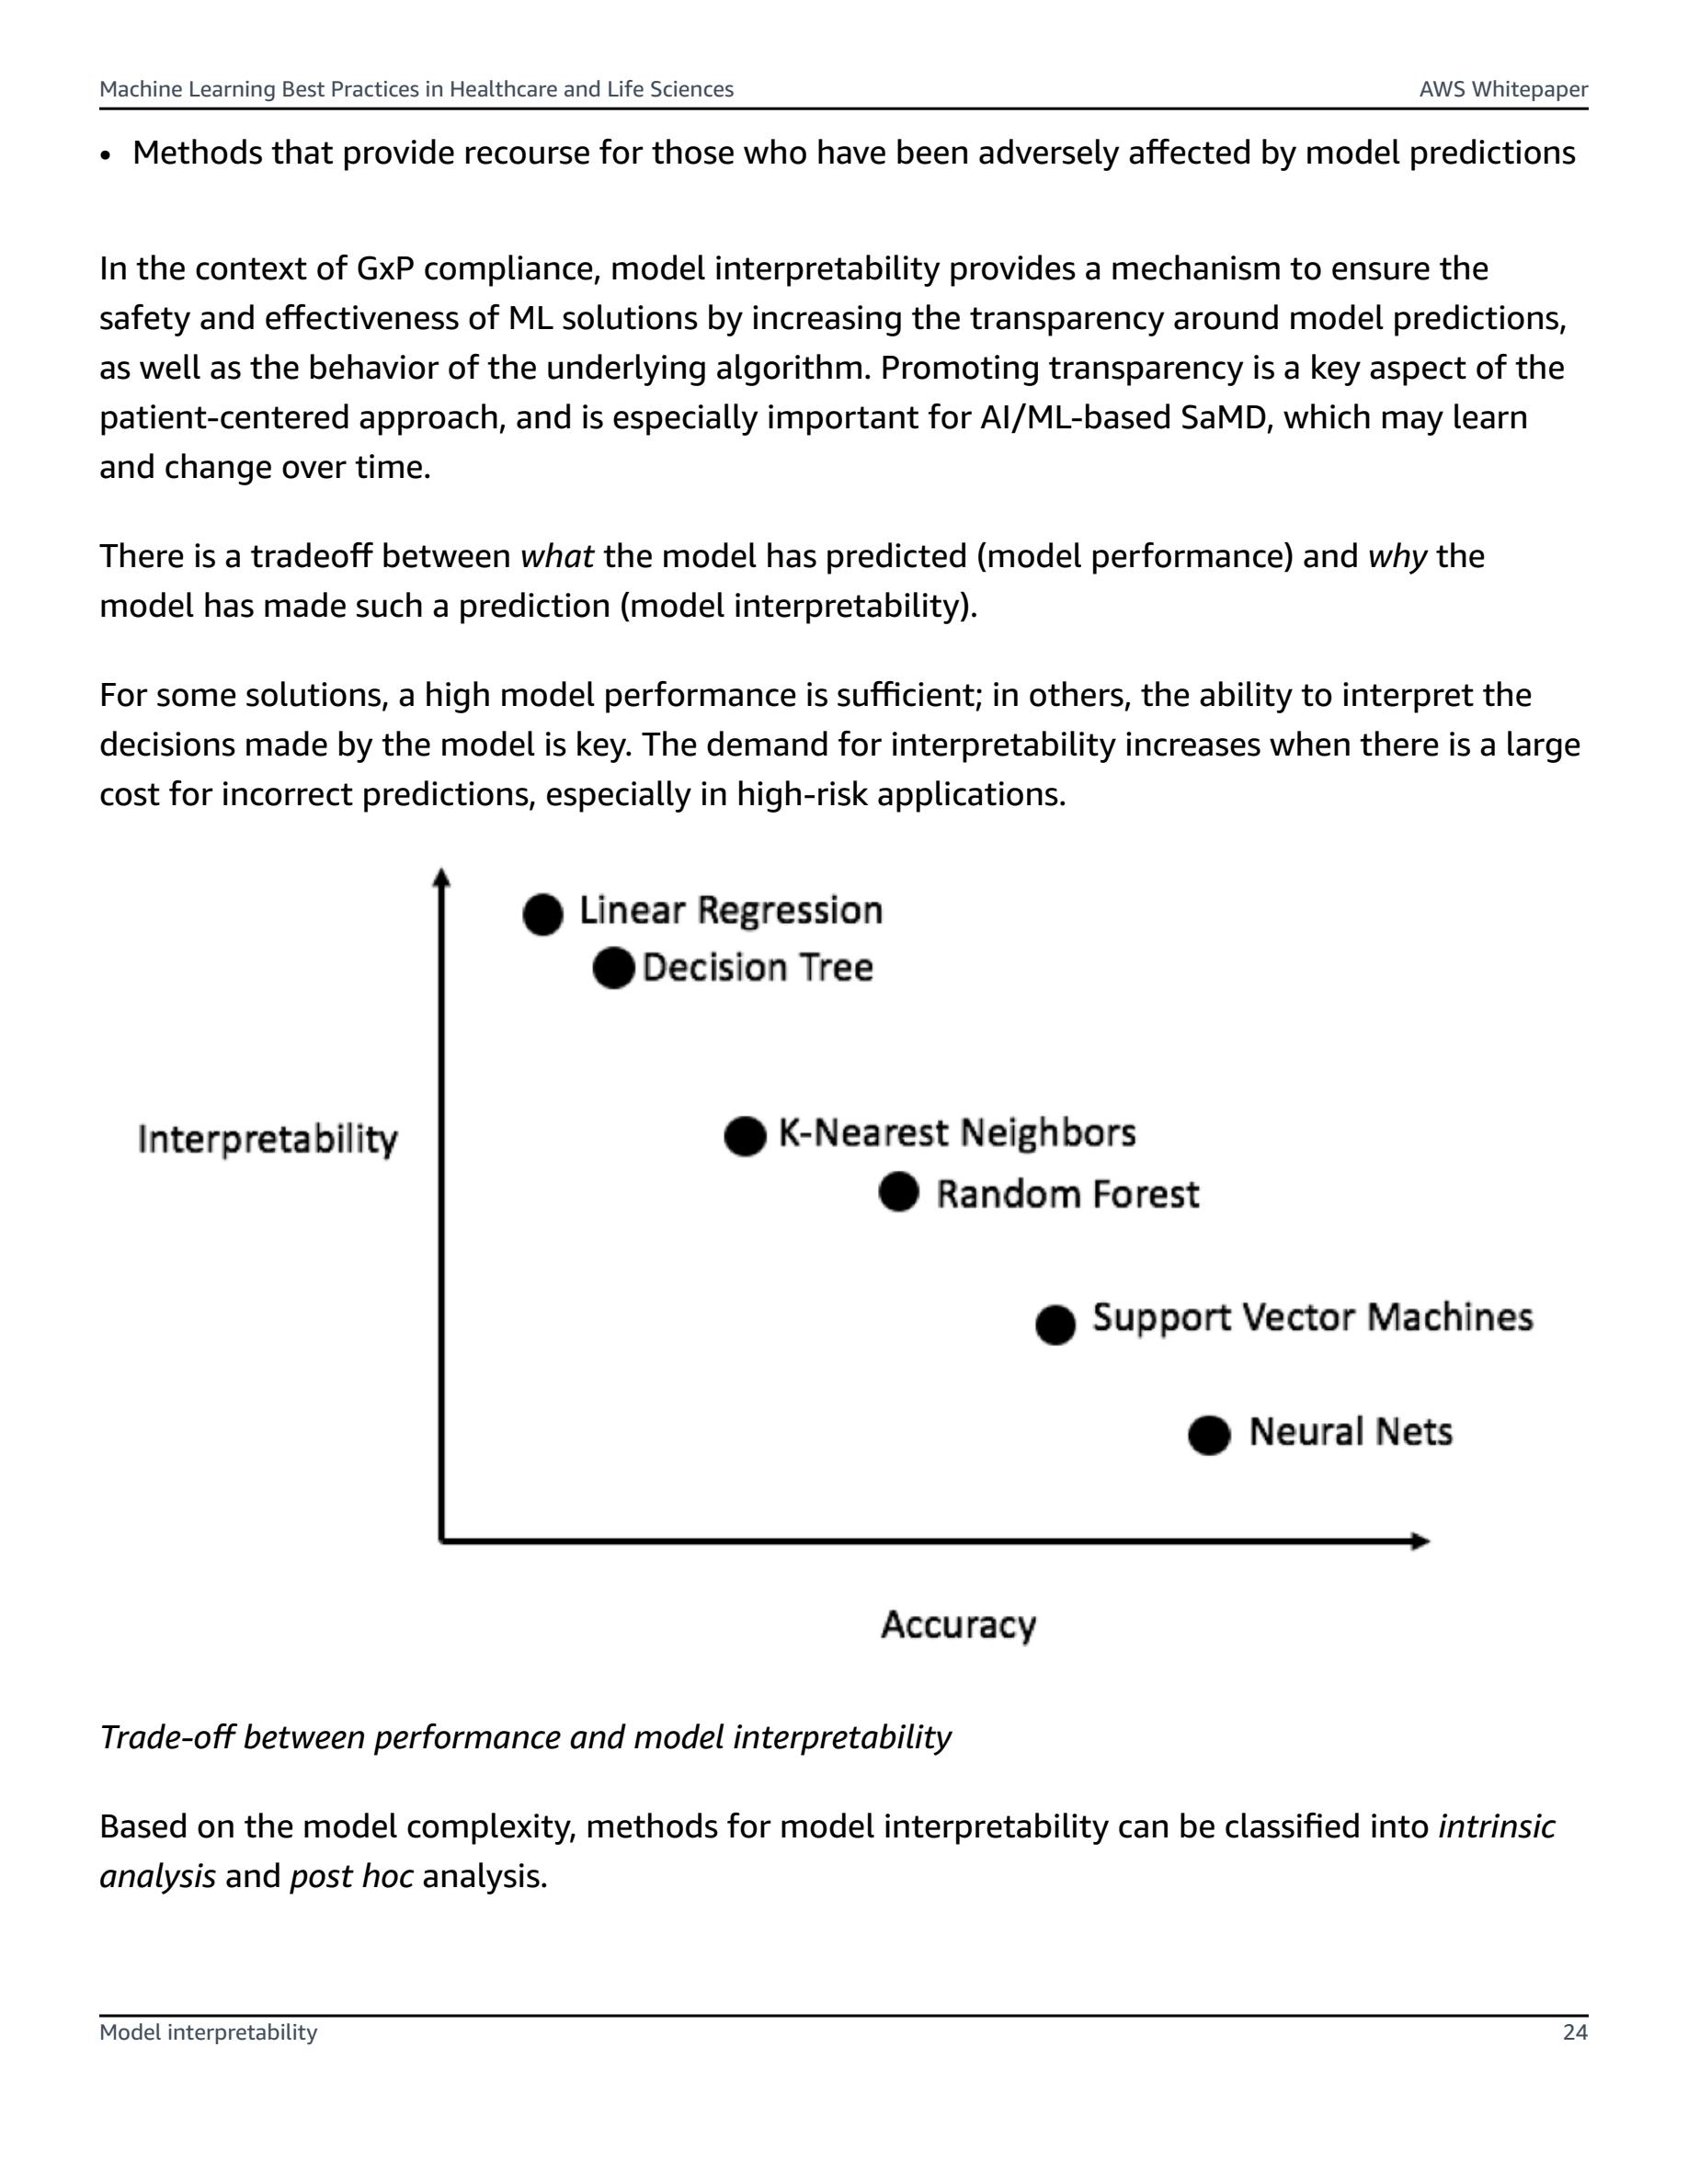

[2024-07-25 00:22:28,115] p17714 {1374067570.py:55} INFO - simple_search is selected, iterating through just the image description
[2024-07-25 00:22:28,116] p17714 {1374067570.py:56} INFO - response source for image: Based on the image, here are the relevant entities I can identify:

Named entities:
- Linear Regression
- Decision Tree
- K-Nearest Neighbors
- Random Forest
- Support Vector Machines
- Neural Nets

These are names of different machine learning models or algorithms mentioned in the image.

Data entities:
- Interpretability
- Accuracy

These are the names of the two metrics or axes shown in the chart, representing model interpretability and model accuracy respectively.

There are no obvious person names, organizations, locations, dates/times, or product names present in this particular image. The entities relate primarily to machine learning concepts and methods.The image is divided into four sections, with text and a visual chart.

Upper Left Section:
This section contains

KeyboardInterrupt: 

In [29]:
question: str = "What are the Trade-offs between performance and model interpretability graph?"
index_clients: List[Tuple] = [(os_client, img_index_name), (os_client, text_index_name)]
search_strategy: str = config['rag_search_pipeline'].get('search_type', 'enhanced_search')
get_index_response(question, config['other_inference_and_eval_metrics']['k_count_retrieval'], index_clients, search_strategy)

#### Question 2:
---

We will ask a question about a specific text in the pdf file on page 22 about automating data integration and deployment

[2024-07-25 00:23:30,831] p17714 {1374067570.py:24} INFO - Going to answer the question: For automating data integration deployment, why do we have to minimize human touch point in deployment pipelines?
[2024-07-25 00:23:30,833] p17714 {1374067570.py:27} INFO - Searching for the answer in the images index:
[2024-07-25 00:23:31,755] p17714 {327181933.py:13} INFO - Entities extracted: ['data integration deployment, human touch point, deployment pipelines, automating', 'DATA INTEGRATION DEPLOYMENT, HUMAN TOUCH POINT, DEPLOYMENT PIPELINES, AUTOMATING']
[2024-07-25 00:23:31,830] p17714 {base.py:258} INFO - POST https://p8iwxd53ehl4qz5no03j.us-west-2.aoss.amazonaws.com:443/images/_search [status:200 request:0.072s]
[2024-07-25 00:23:31,832] p17714 {1374067570.py:27} INFO - Searching for the answer in the texts index:
[2024-07-25 00:23:32,659] p17714 {327181933.py:13} INFO - Entities extracted: ['data integration deployment, human touch point, deployment pipelines, automating', 'DATA INTEGRAT

download: s3://multimodal-rag-poc-bucket-988564344122-us-west-2/multimodal/img/ml-best-practices-healthcare-life-sciences_page_22.jpg to ./ml-best-practices-healthcare-life-sciences_page_22.jpg


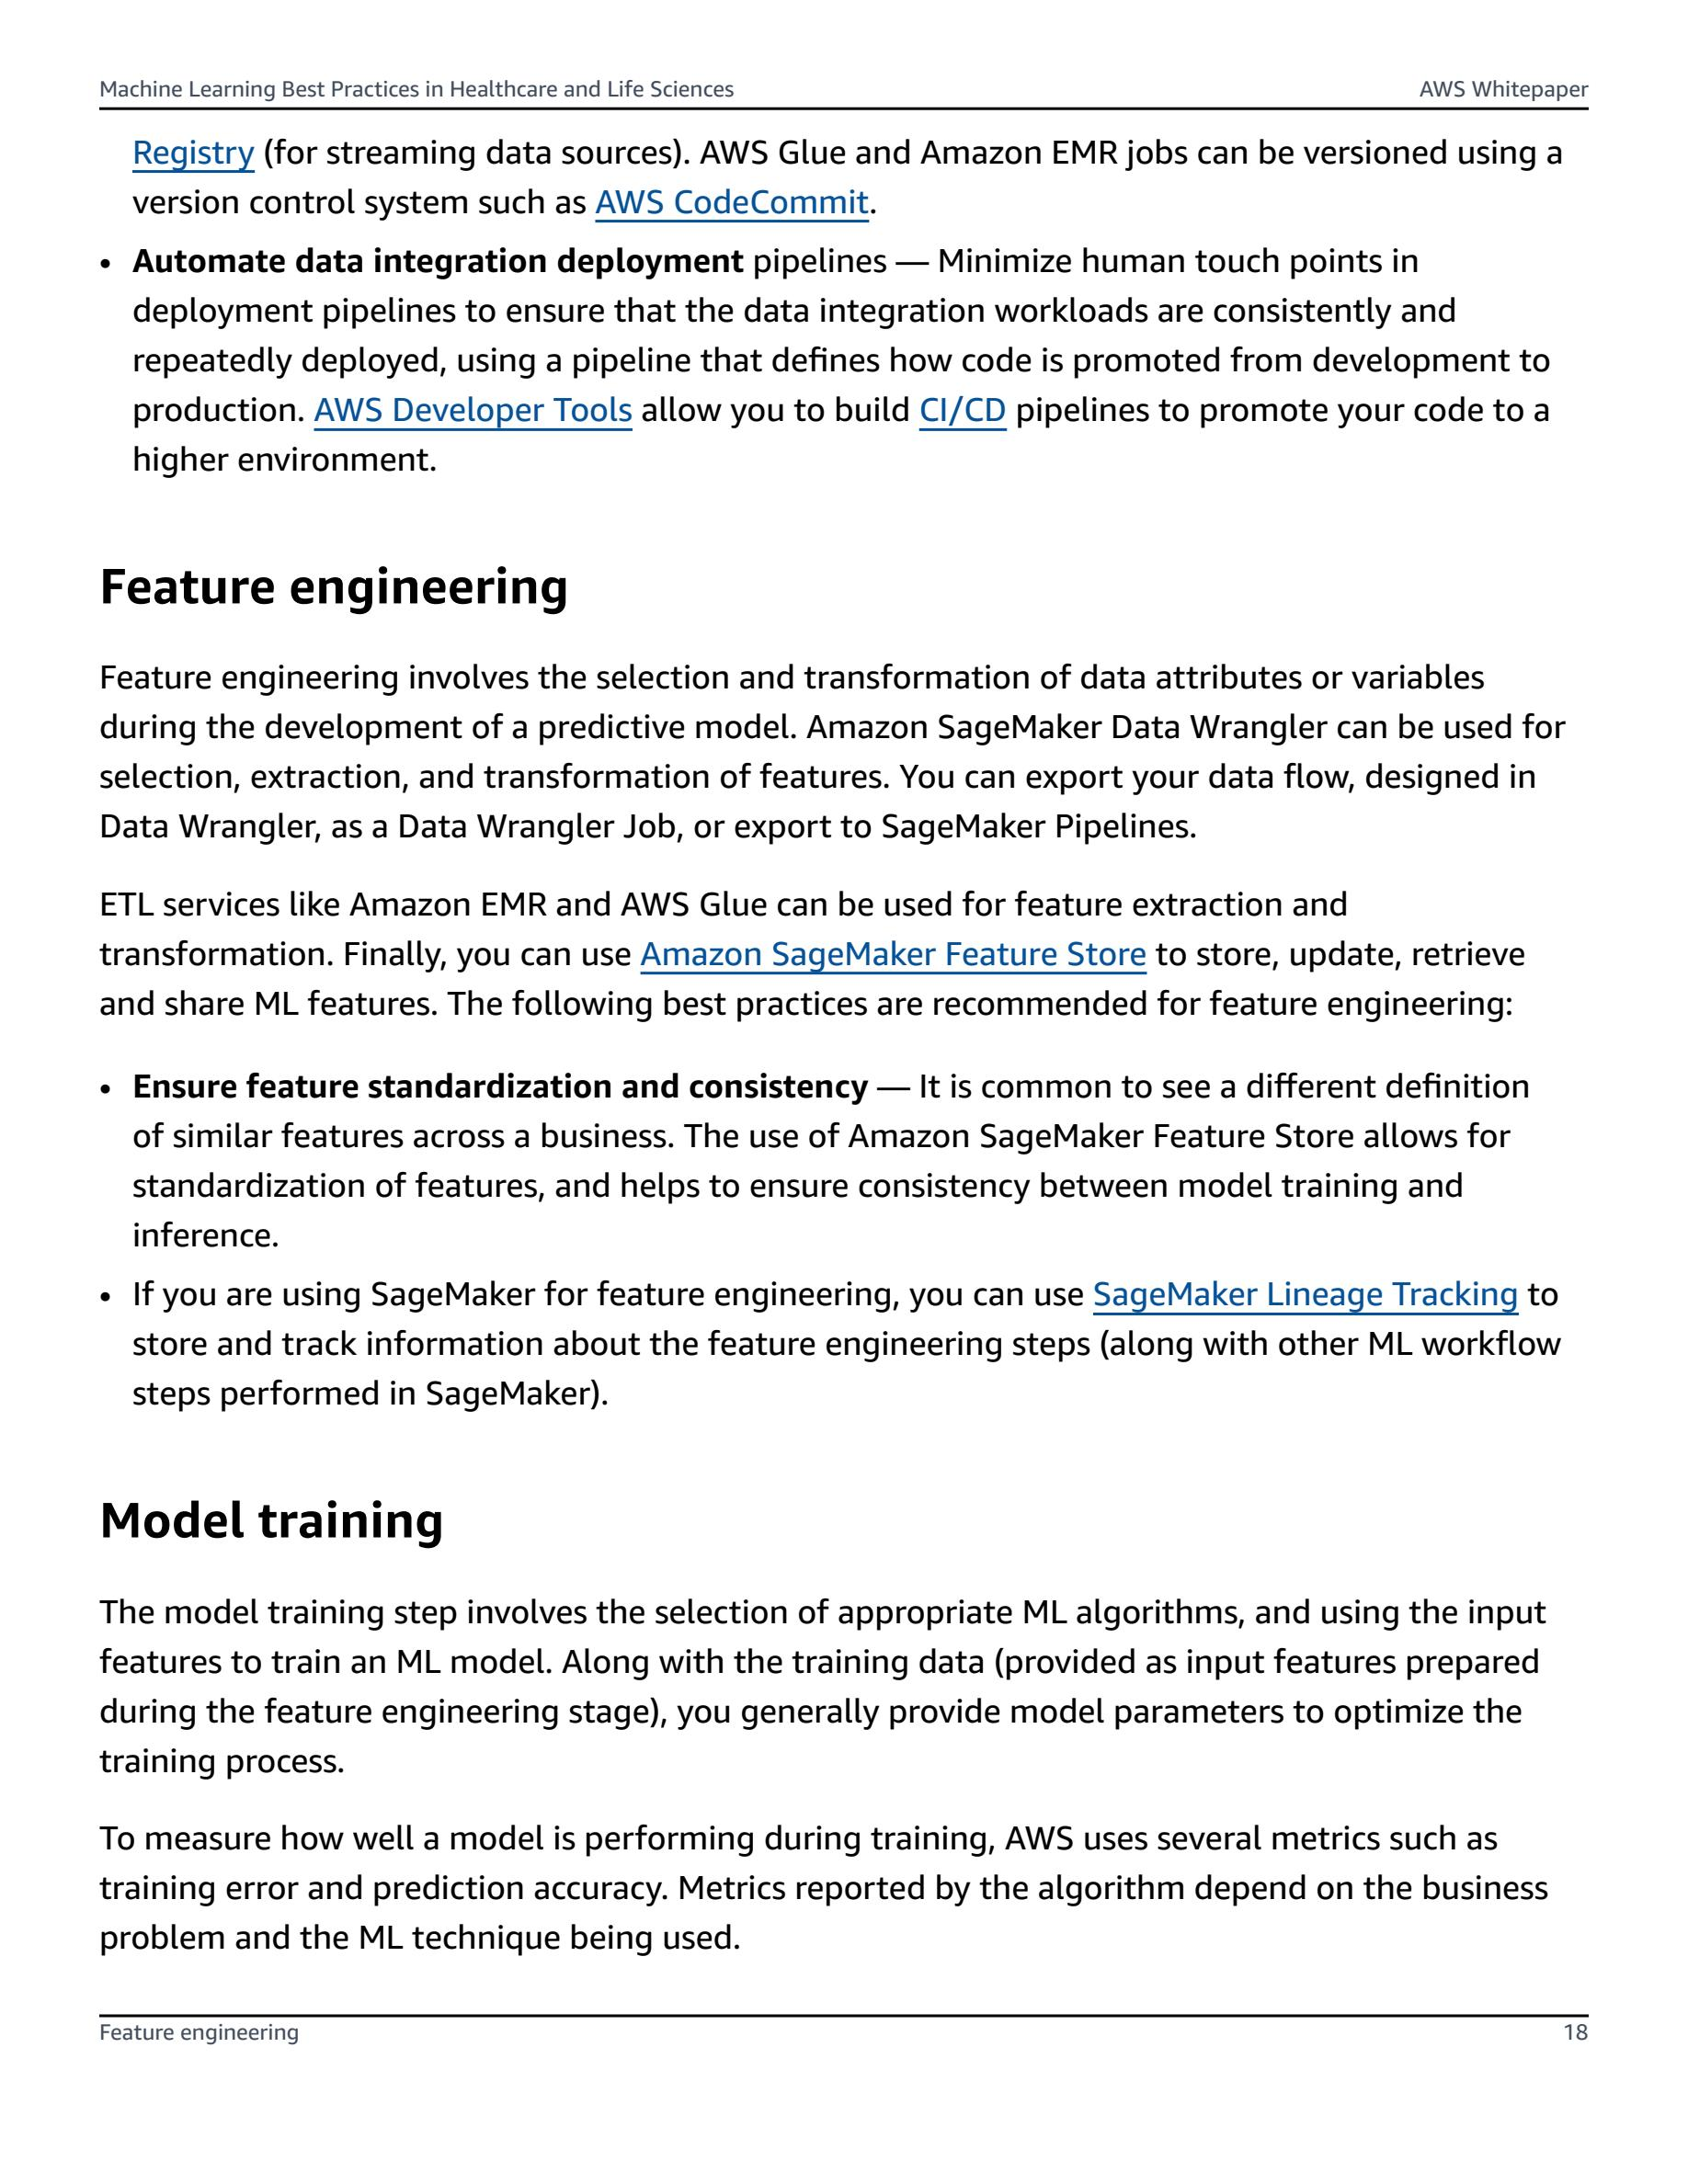

[2024-07-25 00:23:33,646] p17714 {1374067570.py:49} INFO - enhanced_search is selected, iterating through the image description and the image itself
[2024-07-25 00:23:33,647] p17714 {3040793436.py:11} INFO - Nearest image path being used for search: img/b64_images/ml-best-practices-healthcare-life-sciences_page_22.b64
[2024-07-25 00:23:33,687] p17714 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
[2024-07-25 00:23:36,381] p17714 {_client.py:1026} INFO - HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-sonnet-20240229-v1:0/invoke "HTTP/1.1 200 OK"
[2024-07-25 00:23:36,384] p17714 {1374067570.py:53} INFO - response at this iteration for this image: To minimize human touch points in deployment pipelines to ensure that the data integration workloads are consistently and repeatedly deployed, using a pipeline that defines how code is promoted from development to production.
[2024-07-25 00:23:36,385]

{'source': 'to minimize human touch points in deployment pipelines to ensure that the data integration workloads are consistently and repeatedly deployed, using a pipeline that defines how code is promoted from development to production.',
 'response': 'To minimize human touch points in deployment pipelines to ensure that the data integration workloads are consistently and repeatedly deployed, using a pipeline that defines how code is promoted from development to production.',
 'image_input_tokens': 11657,
 'image_output_tokens': 419,
 'text_input_tokens': 0,
 'text_output_tokens': 0,
 'total_input_tokens': 12002,
 'total_output_tokens': 460,
 'total_image_latency': 2.727944,
 'total_text_latency': 0.0,
 'total_combined_latency': 4.360872}

In [35]:
question: str = "For automating data integration deployment, why do we have to minimize human touch point in deployment pipelines?"
index_clients: List[Tuple] = [(os_client, img_index_name), (os_client, text_index_name)]
get_index_response(question, config['other_inference_and_eval_metrics']['k_count_retrieval'], index_clients, search_strategy)

#### Question 3:
---

We will ask an open ended question about an image and text on page 33 about operationalizing AI/ML workloads

In [34]:
question: str = "In Operationalizing AI/ML workloads, what comes under 'Prepare for production'?"
index_clients: List[Tuple] = [(os_client, img_index_name), (os_client, text_index_name)]
get_index_response(question, config['other_inference_and_eval_metrics']['k_count_retrieval'], index_clients, search_strategy)

[2024-07-25 00:23:13,235] p17714 {1374067570.py:24} INFO - Going to answer the question: In Operationalizing AI/ML workloads, what comes under 'Prepare for production'?
[2024-07-25 00:23:13,236] p17714 {1374067570.py:27} INFO - Searching for the answer in the images index:
[2024-07-25 00:23:14,223] p17714 {327181933.py:13} INFO - Entities extracted: ['operationalizing ai/ml workloads, prepare for production', 'OPERATIONALIZING AI/ML WORKLOADS, PREPARE FOR PRODUCTION']
[2024-07-25 00:23:14,275] p17714 {base.py:258} INFO - POST https://p8iwxd53ehl4qz5no03j.us-west-2.aoss.amazonaws.com:443/images/_search [status:200 request:0.049s]
[2024-07-25 00:23:14,275] p17714 {1374067570.py:27} INFO - Searching for the answer in the texts index:
[2024-07-25 00:23:15,043] p17714 {327181933.py:13} INFO - Entities extracted: ['operationalizing ai/ml workloads, prepare for production', 'OPERATIONALIZING AI/ML WORKLOADS, PREPARE FOR PRODUCTION']
[2024-07-25 00:23:15,105] p17714 {base.py:258} INFO - POST h

{'source': '',
 'response': 'Unfortunately, there is no context provided within the summary tags to answer the question "In Operationalizing AI/ML workloads, what comes under \'Prepare for production\'?". Without any relevant information, I do not have enough context to provide a substantive answer.',
 'image_input_tokens': 8849,
 'image_output_tokens': 378,
 'text_input_tokens': 0,
 'text_output_tokens': 0,
 'total_input_tokens': 9157,
 'total_output_tokens': 439,
 'total_image_latency': 0.0,
 'total_text_latency': 0.0,
 'total_combined_latency': 1.324909}

## Eval Dataset Comparison
---

In this section of the notebook we do as follows:

1. Check for if a user has provided an `evaluation dataset` - Any dataset with a question bank and/or target responses

1. Iterate through each question provided in the dataset, and call the `get_index_response` function

1. Record responses from the text response, the image response and combined responses

1. Update the df and store the result in the `eval directory`

In [ ]:
os.makedirs(config['eval_qna_dataset_info']['dir_name'], exist_ok=True)
eval_dataset_file_list = os.listdir(config['eval_qna_dataset_info']['dir_name'])
logger.info(f"Number of evaluation files: {len(eval_dataset_file_list)}")

In [ ]:
if config['eval_qna_dataset_info']['eval_dataset_name'] in eval_dataset_file_list:
    eval_dir = config['eval_qna_dataset_info']['dir_name']
    eval_fpath = os.path.join(eval_dir, config['eval_qna_dataset_info']['eval_dataset_name'])
    eval_file = Path(eval_fpath)
    if eval_file.suffix == '.csv':
        eval_df = pd.read_csv(eval_file)
    elif eval_file.suffix in ['.xls', '.xlsx']:
        eval_df = pd.read_excel(eval_file)
    else:
        raise ValueError(f"Unsupported file format: {eval_file.suffix}")
eval_df.head(10)

### Get responses from combined (both text and image index), along with metrics such as the input/output token count, and latency
---

1. This part of the notebook iterates through an evaluation dataset (if any)

1. Iterates through each user question in a column and generates outputs using the three different ways (combined index approach, text only and image only approaches)

1. Appends all responses from each approach to the original dataframe and saves it as a `CSV` file in the `metrics` directory for further evaluations and downstream tasks.

1. Calculates the aggregate metrics from the image, text and combined (image and text responses) such as the prompt token count, completion token count, and latency (in seconds) at each iteration.

In [ ]:
# initialize the index clients to run inferences against the evaluation dataset provided by the user
index_clients_both = [(os_client, text_index_name), (os_client, img_index_name)]
text_index_client = [(os_client, text_index_name)]
img_index_client = [(os_client, img_index_name)]

In [ ]:
# iterate through the evaluation dataframe and record responses for the question bank
# using the text, image and both indexes combined for further evaluations
def evaluate_responses(eval_df, index_clients_both, text_index_client, img_index_client):
    try:
        question_key = config['eval_qna_dataset_info']['question_key']
        k_count_retrieval = config['other_inference_and_eval_metrics']['k_count_retrieval']
        for i, question in enumerate(eval_df[question_key]):
            # populate the dataframe with the combined response, token counts, and source
            combined_response = get_index_response(question, k_count_retrieval, index_clients_both, search_strategy)
            eval_df.at[i, 'combined_response'] = combined_response['response']
            eval_df.at[i, 'combined_total_input_tokens'] = combined_response['total_input_tokens']
            eval_df.at[i, 'combined_total_output_tokens'] = combined_response['total_output_tokens']
            eval_df.at[i, 'total_combined_latency'] = combined_response['total_combined_latency']
            eval_df.at[i, 'image_and_text_source'] = combined_response['source']
            # populate the dataframe with response from the text only index
            text_response = get_index_response(question, k_count_retrieval, text_index_client, search_strategy)
            eval_df.at[i, 'text_response'] = text_response['response']
            eval_df.at[i, 'text_index_input_tokens'] = text_response['text_input_tokens']
            eval_df.at[i, 'text_index_output_tokens'] = text_response['text_output_tokens']
            eval_df.at[i, 'total_text_latency'] = text_response['total_text_latency']
            eval_df.at[i, 'text_source'] = text_response['source']
            # populate the dataframe with response from the image only index
            image_response = get_index_response(question, k_count_retrieval, img_index_client, search_strategy)
            eval_df.at[i, 'img_response'] = image_response['response']
            eval_df.at[i, 'image_index_input_tokens'] = image_response['image_input_tokens']
            eval_df.at[i, 'image_index_output_tokens'] = image_response['image_output_tokens']
            eval_df.at[i, 'total_image_latency'] = image_response['total_image_latency']
            eval_df.at[i, 'img_source'] = image_response['source']
            logger.info(f"Combined response: {combined_response['response']}")
    except Exception as e:
        logger.error(f"Cannot generate inferences to the provided questions in the dataset: {e}")
        eval_df = None
    return eval_df

In [ ]:
final_eval_df = evaluate_responses(eval_df, index_clients_both, text_index_client, img_index_client)
metrics_dir = config['dir_info']['metrics_dir_name']
os.makedirs(metrics_dir, exist_ok=True)
side_view_eval_file = os.path.join(metrics_dir, config['eval_qna_dataset_info']['updated_eval_file'])
final_eval_df.to_csv(side_view_eval_file, index=False)
final_eval_df.head(10)

#### Record the p95 count for the input/output token lengths and total latency for text, image, and combined search

In [ ]:
latency_cols_of_interest = ['total_text_latency', 'total_image_latency', 'total_combined_latency']
token_cols_of_interest = [
    'combined_total_input_tokens', 'combined_total_output_tokens',
    'text_index_input_tokens', 'text_index_output_tokens',
    'image_index_input_tokens', 'image_index_output_tokens'
]

p95_metrics_summary: str = ""

# Calculate p95 for latency columns
for c in latency_cols_of_interest:
    quantiles = list(round(final_eval_df[c].quantile([0.5, 0.95]), 2))
    s = f"[p50, p95] for {c} = {quantiles}\n"
    p95_metrics_summary += s
    logger.info(s)

# Calculate p95 for token count columns
for c in token_cols_of_interest:
    quantiles = list(round(final_eval_df[c].quantile([0.5, 0.95]), 2))
    s = f"[p50, p95] for {c} = {quantiles}\n"
    p95_metrics_summary += s
    logger.info(s)

p95_metric_fpath: str = os.path.join(metrics_dir, config['dir_info']['p95_metrics_file'])
Path(p95_metric_fpath).write_text(p95_metrics_summary)

In [ ]:
print(p95_metrics_summary)